In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
import pickle
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.layers.embeddings import Embedding
from google.colab import drive
import copy
drive.mount('/content/gdrive')


# The following code in the cell loads the dataset, and forms the training data. Then preprocesses the sentences and tokenizes the all the words in the dataset 
# and pads the sentences and represents each sentence by the token values of the words in the sentence


with open("/content/gdrive/My Drive/DL_Project/sentence_list_and_reference_data_revision2.pickle","rb") as f:
  example_dict = pickle.load(f)
  list_data,all_sentences=example_dict


for i in range(len(all_sentences)):
  all_sentences[i]="<start> "+all_sentences[i]+" <end>"

with open("/content/gdrive/My Drive/DL_Project/training_indexes_from_total_data.pickle","rb") as f:
  training_indexes_in_total = pickle.load(f)

all_sentences_training=[all_sentences[i] for i in training_indexes_in_total]
  
tokenizer = Tokenizer(filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(all_sentences_training)

sentences_to_encode = all_sentences_training



encoded_sentences = tokenizer.texts_to_sequences(sentences_to_encode)

word_to_index=tokenizer.word_index
index_to_word = dict((v,k) for k,v in word_to_index.items())

word_to_index['<pad>']=0
index_to_word[0]='<pad>'

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(encoded_sentences, padding='post')

vocab_size = max(max(i) for i in encoded_sentences) + 1


Using TensorFlow backend.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!unzip "/content/gdrive/My Drive/DL_Project/Flickr8k_Dataset.zip"

In [0]:
"""
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()

!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
"""


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130812 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
"""
!mkdir /content/gdrive
!google-drive-ocamlfuse /content/gdrive
!ls /content/gdrive
"""

'Colab Notebooks'   DL	'Getting started'  'IU_2 Projects.ods'


In [0]:
# Here we are loading the 2048-dimensional image representation of all the images in the dataset and forming a list of 2048 dimensional representation of images that belong to training set 


# We have 30,000 training examples for this project. Containing 6000 unique images with more than one captions for each image. 

with open("/content/gdrive/My Drive/DL_Project/imagenet_names_vectors_ordered_revision2.pkl","rb") as f:
  example_dict_2 = pickle.load(f)
  imagenet_names,imagenet_vectors=example_dict_2


img_vec_names=[imagenet_names[i] for i in training_indexes_in_total]
img_vecs=[imagenet_vectors[i] for i in training_indexes_in_total]
sen_vecs=copy.copy(cap_vector)

In [0]:
import random

#The program in this cell is almost the same as the image-caption-generation .ipynb file program in the same cell. we are going to restore the saved checkpoint and run the model for furthur tasks in this file.
#this file contains, the tasks of finding similar images, finding similar words, and inferring image when provided with caption




class CNN_Encoder(tf.keras.Model):
    
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x=tf.expand_dims(x,1)
        x = self.fc(x)
        x = tf.nn.relu(x)
        x=tf.reshape(x,[tf.shape(x)[0],300])
        return x

    
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(5581)
    self.embedding = tf.keras.layers.Embedding(5581, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',stateful=True,batch_input_shape=(1,1, 300))
    
  def call(self, x, features, flags_embedding=1):
    x = self.embedding(x)
    if flags_embedding==0:
      return x
    x = tf.concat([tf.expand_dims(features, 1), x], axis=-1)
    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)

    return x, state


  
def train_step(image_vector_for_processing, label_sentence):
  
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * 1, 1)
  loss = 0
  
  with tf.GradientTape() as tape:
      features = encoder(image_vector_for_processing)
      
      for i in range(1, label_sentence.shape[1]):
          predictions, hidden = decoder(dec_input, features)
          loss += loss_function(label_sentence[:, i], predictions)
          dec_input = tf.expand_dims(label_sentence[:, i], 1)
  total_loss = (loss / int(label_sentence.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))
  return loss, total_loss
  

embedding_dim=300
units=516
vocab_size=5581


encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

adam_lr=0.0001
optimizer = tf.keras.optimizers.Adam(lr=adam_lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')





def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)


num_steps=30000
batch=1

adam_lr=0.0001

loss_plot = []


#Use the checkpoint snaps from your trained, image-caption-generation-training .ipynb file

checkpoint_path ="/content/gdrive/My Drive/DL_Project/Revised_training_seq/TRAIN_3/ckpt-318"
ckpt = tf.train.Checkpoint(encoder=encoder,decoder=decoder,optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

status=ckpt.restore("/content/gdrive/My Drive/DL_Project/Revised_training_seq/TRAIN_3/ckpt-318")




In [0]:
def evaluate(image):
    #attention_plot = np.zeros((max_length, attention_features_shape))

    #hidden = decoder.reset_state(batch_size=1)

    #temp_input = tf.expand_dims(load_image(image)[0], 0)
    #img_tensor_val = image_features_extract_model(temp_input)
    #img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(image)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden = decoder(dec_input, features)

        #attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    #attention_plot = attention_plot[:len(result), :]
    return result



with open("/content/gdrive/My Drive/DL_Project/test_image_vectors_and_names.pkl","rb") as f:
  example_dict = pickle.load(f)
  test_image_vectors,test_image_names=example_dict

#print(len(test_image_names))
max_length= max(len(t) for t in encoded_sentences)

for i in range(0,500,10):
  print(test_image_names[i])
  print(evaluate([test_image_vectors[i]]))

In [0]:
#def image_from_sent(l):
#var=np.random.uniform(low=0,high=2.5, size=(1,300))
#with tf.variable_scope("foo"):
v = tf.Variable(tf.random.uniform((1,300),minval=0,maxval=0.5,dtype=tf.dtypes.float32))
print("random vec-",v)
l=np.array([sen_vecs[0]])

print("target-",l)

#feature randon generated vector
#target list of word_to_emd[word] 
def train_step_input_var(features, target):
  loss = 0
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * 1, 1)

  with tf.GradientTape() as tape:
      #features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden = decoder(dec_input, features)
          #print(np.shape(dec_input))

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = [features]

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss, features

#print(np.shape(l))
for i in range(2):
  print(i)
  k,m,n=train_step_input_var(v,l)
  print(n)
print("\n\nafter training-")
print(k)
print(m)
print(n)

In [0]:
#Function whick takes 2048 vector of the image and return 300 vector embedding of that specific image (This uses the encoder function thereby uses the network parameters)
def image_2048_300(image):
  #encoder(image)
  return np.array(encoder([image]))[0]

#Function whick takes word, thereby gets it index from word to index dictionary and therby gets its 300 vector embedding of that specific word (This uses the decoder function thereby uses the network parameters)
def word_300(word):
  return np.array(decoder(word_to_index[word],0,0))

In [0]:
#getting the image names and image's inception 2048 vector from already loaded data

image_names = []
image_vectors = []
for i in range(len(imagenet_names)):
  if imagenet_names[i] not in image_names:
    image_names.append(imagenet_names[i])
    image_vectors.append(imagenet_vectors[i])
  else:
    continue
    
print (len(image_names))
print (len(image_vectors))

In [0]:
#converting image 2048 vectors to 300 dimentional vectors

image_300_vectors = []
for i in range(len(image_names)):
  image_300_vectors.append(image_2048_300(image_vectors[i]))

In [0]:
#Getting each word from the vocabulary (Which we got from training data), and getting its 300 dimentional embedding
word_300_vectors = []
word_list = []
for i in word_to_index:
  word_300_vectors.append(decoder(word_to_index[i],0,0))
  word_list.append(i)

In [0]:
#Function to give 10 simialr images(names) for a given image 300 dimentional vector
#This caluclate the cosine similarity (Dot Product) and gice the top 10 simialr image names
#input image is 300 dimention vector of the input image
def similar_images(input_image, image_300_vectors, image_names):
  
  dot_list = []
  for i in range(len(image_300_vectors)):
    dot_list.append(np.dot(input_image, image_300_vectors[i]))


  dot_list_sorted = sorted(dot_list)

  print(dot_list)
  print(dot_list_sorted[-10:])

  
  for i in dot_list_sorted[-10:]:
    print (image_names[dot_list.index(i)])

In [0]:
#the first image being printed is our input image and the following images being printed are the images which are similar to the first image. The images can be checked in the dataset provided.

# the similar images are printed in the order of increaing similarity

print (image_names[2])
input_image = image_300_vectors[2]
similar_images(input_image, image_300_vectors, image_names)


1358089136_976e3d2e30.jpg
[6.790247, 3.9816842, 32.7768, 4.8881254, 15.489834, 5.139721, 4.0664167, 8.667202, 8.389732, 11.524192, 11.024042, 3.8777995, 8.212101, 14.961263, 19.735752, 12.168253, 19.589825, 10.631462, 18.52127, 7.8836784, 7.579386, 8.894315, 19.770222, 23.322964, 3.1293156, 5.3977957, 9.11949, 3.8498363, 8.081469, 7.133294, 11.107498, 22.168144, 13.603482, 24.738928, 6.409997, 17.863686, 7.9310303, 7.6673036, 11.256102, 11.50799, 4.0688496, 8.252747, 18.68179, 4.385547, 13.161158, 9.128517, 6.1971197, 9.323449, 7.1648955, 9.258748, 5.727522, 3.2359254, 11.107723, 4.698308, 5.2824097, 4.399994, 4.949618, 6.012439, 8.188636, 7.915183, 9.237802, 12.005541, 3.2533336, 13.020502, 17.12603, 10.290007, 9.056448, 3.6804047, 6.3618226, 4.816064, 20.16467, 6.694565, 4.553829, 4.8017826, 5.033755, 7.069579, 6.4905977, 4.9591866, 5.9980373, 12.651726, 8.411154, 7.8030148, 5.450051, 6.1117415, 5.3550043, 5.6793084, 3.887522, 12.068629, 5.5325594, 5.9264126, 8.188788, 3.636476, 8.85

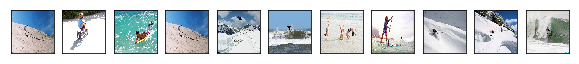

In [6]:
from tensorflow.python.keras.preprocessing import image
import matplotlib.pyplot as plt

img_collection=[]
image_names_1 = ['1358089136_976e3d2e30.jpg','2544182005_3aa1332bf9.jpg','412203580_2c7278909c.jpg','1358089136_976e3d2e30.jpg','513116697_ad0f4dc800.jpg','3724581378_41049da264.jpg','3747543364_bf5b548527.jpg','3376014640_ff5b00769f.jpg','3156406419_38fbd52007.jpg','270809922_043e3bef06.jpg','3216829599_366a43f05e.jpg']
for img in image_names_1:
  img_collection.append(np.uint8(image.img_to_array(image.load_img("/content/Flicker8k_Dataset/" + img, target_size=(100, 100)))))
  

fig=plt.figure(figsize=(10, 1))
      
for i in range(1, 12):          
    img_1 = img_collection[i-1]          
    fig.add_subplot(1, 11, i)          
    plt.imshow(img_1)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [0]:
#Function to give 10 similar words from the vocabulary for a given word
#This caluclate the cosine similarity (Dot Product) and gice the top 10 simialr words
#input word is  word
#First we get the word embedding vector then caluclate the cosine similarity with other words

def similar_words(input_word, word_300_vectors, word_list):
  if input_word not in word_list:
    print ("word not present in vocab")
  
  else:
    input_word_vector = decoder(word_to_index[input_word],0,0)
    dot_list = []
    for i in range(len(word_300_vectors)):
      dot_list.append(np.dot(input_word_vector, word_300_vectors[i]))


    dot_list_sorted = sorted(dot_list)

    #print(dot_list)
    #print(dot_list_sorted[-10:])

    print (input_word)
    for i in dot_list_sorted[-10:]:
      print (word_list[dot_list.index(i)])

In [0]:
input_word = "black"
similar_words(input_word, word_300_vectors, word_list)

#Here black is the word we are giving as input and the following words are similar words.
# the similar words are printed in the order of increaing similarity

[0.35648713, -0.12604783, -0.021092003, -0.2184343, 0.15186842, 0.08794765, -0.25577903, -0.045895424, 0.015043406, 0.17747582, -0.15309428, 0.02481985, 0.25359935, 0.10221249, 0.12960435, 0.004311707, 0.17864732, 0.63068473, 0.9101765, 0.19042909, 0.030536037, -0.038794957, -0.15790918, 0.09551345, -0.47095057, -0.13419606, 0.08157548, 0.45841014, -0.087814316, 0.14511797, 0.8504014, -0.111811735, 0.40353355, 0.44686595, 0.1356866, -0.16789734, 0.14402588, 0.15024701, -0.17167157, -0.12248037, -0.05248352, -0.041072425, -0.2836725, 0.08919783, -0.103332795, -0.047201075, 0.12026619, -0.16323556, -0.07507316, 0.23725636, 0.29452398, 0.2133725, -0.083858974, -0.13037173, 0.36631742, -0.16367267, -0.22065671, 0.5765655, 0.016624, 0.1501839, -0.23406543, -0.030068938, -0.08005644, -0.025159776, -0.21157126, 0.056268632, -0.0054352176, -0.030508406, 0.056763534, -0.17971998, -0.06465098, 0.16050525, -0.19629197, 0.35864785, -0.26624927, -0.18662997, -0.09353969, -0.51309365, -0.0657313, 0.

In [0]:
#The following portion of the program  is to infer an image, given, the caption. Here we define a randomly generated 300 dimensional array 
# where the values are sampled from a uniform distribution. we pass this 300 dimensional tensor in place of the image embedding and reduce the loss while having
# the weights in the model fixed and only updating the randomly initialized variable. This has been explained with more detail in the report.

v = tf.Variable(tf.random.uniform((1,300),minval=0,maxval=0.5,dtype=tf.dtypes.float32))

#Creating a numpy array to pass the user input sequence as required by the model, as the maximum length of the sentence is 39, we have created same length array
ll = np.zeros((39,),dtype=np.int8)
print (ll)

In [0]:
#Creating tokenize representation for Captions
#Filling the caption index array 
ind = 0

#User entered caption
s = "people play football"
for i in s.split(" "):
  ind_ind = word_to_index[i]
  print (i, ind_ind)
  ll[ind] = ind_ind
  ind += 1

print (ll)
ll = np.array([ll])
print (ll)


 

In [0]:

#code to give updated input vector for the given caption

print("random vec-",v)
#l=np.array([sen_vecs[0]])

print("target-",ll)

#feature randon generated vector
#target list of word_to_emd[word] 

#print(np.shape(l))
for i in range(1000):
  print(i)
  k,m,n=train_step_input_var(v,ll)
  #print(n)
print("\n\nafter training-")
#print(k)
#print(m)
print(n)



In [0]:
#getting simialr images for the updated input image vector
similar_images(n[0], image_300_vectors, image_names)

#The below images are the results for the input caption "people play football", by looking at these images in database we can see people playing football in the images

# the similar images are printed in the order of increaing similarity

[1.4084619, 3.4961104, 3.1449234, 1.7242583, 3.2821152, 5.5338573, 3.6683562, 2.5287955, 2.5587807, 2.3228703, 1.8690928, 3.0733032, 2.0481465, 2.5478616, 3.1049755, 1.5421543, 1.8239868, 3.6643422, 3.4737313, 4.03838, 2.1928174, 1.2239448, 2.5196102, 2.5336874, 1.638102, 2.5633204, 2.1578918, 4.936968, 2.359328, 4.310589, 1.5797529, 1.8659172, 4.0627775, 1.3129536, 2.1933472, 2.593751, 4.7498455, 2.9364972, 2.9992032, 3.4854858, 3.593056, 0.68206596, 1.5907907, 2.045341, 3.444153, 2.5520954, 1.8644879, 2.1724513, 1.7781389, 2.179597, 2.3842351, 3.331754, 2.0134592, 2.8339314, 4.278182, 1.6387306, 2.1770062, 2.7253623, 2.6726527, 1.0253601, 3.1603558, 2.3384612, 2.3676453, 2.407135, 3.4751012, 1.1061887, 1.1166018, 3.4194086, 2.9825177, 2.6750734, 1.5619442, 3.1941836, 2.666146, 2.5492837, 5.779859, 2.4810357, 1.5935335, 3.0916448, 2.416531, 6.72273, 2.246636, 3.7267447, 5.257591, 3.9694479, 1.7458535, 3.9779134, 4.20597, 4.4260254, 2.203583, 5.1316123, 3.7673817, 2.169924, 2.377001, 3

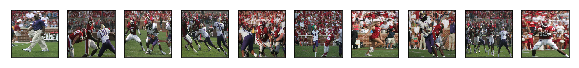

In [7]:
#In the below images we can see that the task is being performed successfully!!!

img_collection=[]
image_names_1 = ['241347635_e691395c2f.jpg','241345981_1ef4f8109c.jpg','241347150_5ff37818c2.jpg','241346508_0b3907a95b.jpg','241345323_f53eb5eec4.jpg','241346352_c5a0ea43c6.jpg','241345656_861aacefde.jpg','241345427_ece0d186c2.jpg','241346580_b3c035d65c.jpg','241347496_1a35fec8dc.jpg']
for img in image_names_1:
  img_collection.append(np.uint8(image.img_to_array(image.load_img("/content/Flicker8k_Dataset/" + img, target_size=(100, 100)))))
  

fig=plt.figure(figsize=(10, 1))
      
for i in range(1, 11):          
    img_1 = img_collection[i-1]          
    fig.add_subplot(1, 10, i)          
    plt.imshow(img_1)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [0]:
#Getting test data resulat to get BLEU metric for image captioning task
with open("Flickr8k.lemma.token.txt", "r") as fp:
  token_data = fp.readlines()

In [0]:
print (token_data[0].split("\t")[0].split("#")[0])
print (token_data[0].split("\t")[1].strip().split(" "))

1305564994_00513f9a5b.jpg
['A', 'man', 'in', 'street', 'racer', 'armor', 'be', 'examine', 'the', 'tire', 'of', 'another', 'racer', "'s", 'motorbike', '.']


In [0]:
#Creating dictionary as required for the BLEU score caluclation
dict_captions = {}
for i in range(len(token_data)):
  req_list = token_data[i].split("\t")[1].strip().lower().split(" ")
  if req_list[-1] == '.':
    req_list = req_list[:-1]
  else:
    pass
  if token_data[i].split("\t")[0].split("#")[0] in dict_captions:
    dict_captions[token_data[i].split("\t")[0].split("#")[0]].append(req_list)
  else:
    dict_captions[token_data[i].split("\t")[0].split("#")[0]] = []
    dict_captions[token_data[i].split("\t")[0].split("#")[0]].append(req_list)


In [0]:
#Creating the reference text(text data actual output) and candidate text(model output) lists
references = []
candidates = []
#count = 0
for i in range(len(test_image_names)):
#  if test_image_names[i] in dict_captions:
 #   count += 1
  candidates.append(evaluate([test_image_vectors[i]])[:-1])
  references.append(dict_captions[test_image_names[i]])

print (len(candidates))
print (len(references))
print (test_image_names[0])
print (candidates[0])
print (references[0])

#print (count)
"""
  print(test_image_names[i])
  print(evaluate([test_image_vectors[i]]))
"""

In [0]:
#Caluclating the BLEU scores using NLTK

from nltk.translate.bleu_score import corpus_bleu
#from nltk.translate.bleu_score import sentence_bleu

print('Cumulative 1-gram: %f' % corpus_bleu(references, candidates, weights=(1, 0, 0, 0)))
print('Cumulative 2-gram: %f' % corpus_bleu(references, candidates, weights=(0.5, 0.5, 0, 0)))
print('Cumulative 3-gram: %f' % corpus_bleu(references, candidates, weights=(0.33, 0.33, 0.33, 0)))
print('Cumulative 4-gram: %f' % corpus_bleu(references, candidates, weights=(0.25, 0.25, 0.25, 0.25)))

#score = corpus_bleu(references, candidates)
#print(score)

Cumulative 1-gram: 0.448359
Cumulative 2-gram: 0.242923
Cumulative 3-gram: 0.126928
Cumulative 4-gram: 0.067869
